# **TASK-3** - Customer 360
---
- You are expected to share insights and a pilot plan to increase the customer retention rate. 
- Your task includes creating a model to identify which customers are predicted to have a high value and which customers are likely to churn. 
- You are also encouraged to create an analysis and proposal on what you think the company should do, utilizing machine learning. 
- You can also help the Sales Director with the personalization by recommending the right product for the right users, or in short: what products we should offer to them

## **Import Data and Library**

In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('retail_transaction_data.csv')
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


- Checking for Data Composition

In [63]:
pd.DataFrame({
    'features': df.columns.values,
    'data_type': df.dtypes.values,
    'null_values': df.isna().mean().values * 100,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
})

,features,data_type,null_values,n_unique,sample_unique
0,order_id,object,0.000000,53628,"[489434, 489435, 489436, 489437, 489438, 48943..."
1,product_id,object,0.000000,5305,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
2,product_description,object,0.410541,5698,"[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE..."
3,quantity,int64,0.000000,1057,"[12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,..."
4,order_date,object,0.000000,47635,"[2009-12-01 07:45:00, 2009-12-01 07:46:00, 200..."
5,unit_price,float64,0.000000,2807,"[6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75..."
6,customer_id,float64,22.766873,5942,"[13085.0, 13078.0, 15362.0, 18102.0, 12682.0, ..."
7,country,object,0.000000,43,"[United Kingdom, France, USA, Belgium, Austral..."


In [64]:
df['product_description'].unique()

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'mixed up',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [65]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [66]:
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## **PREDICTIVE MODEL**

### **CUSTOMER LIFETIME VALUE**


**Goals** : Identify which of new customers are predicted to have a high value. By calculating the CLV on the already existing dataset we can create a Machine Learning model so when we acquire new customers, we can predict their value based on their characteristics.

**Workflow**:
Create new dataset where it shows each customers CLV.
- Drop missing values on customer_id rows
- Drop Cancelled orders
- Calculate Total Revenue per Customer
- Calculate Number of Orders per Customer:
- Calculate Average Order Value (AOV):
- Calculate Recency & Frequency
- Calculate Customer Lifespan

In [67]:
df = df.dropna(subset=['customer_id'])
df = df[df['quantity'] > 0]

In [68]:
pd.DataFrame({
    'features': df.columns.values,
    'data_type': df.dtypes.values,
    'null_values': df.isna().mean().values * 100,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
})

,features,data_type,null_values,n_unique,sample_unique
0,order_id,object,0.0,36975,"[489434, 489435, 489436, 489437, 489438, 48943..."
1,product_id,object,0.0,4631,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
2,product_description,object,0.0,5283,"[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE..."
3,quantity,int64,0.0,438,"[12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,..."
4,order_date,datetime64[ns],0.0,34591,"[2009-12-01 07:45:00, 2009-12-01 07:46:00, 200..."
5,unit_price,float64,0.0,666,"[6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75..."
6,customer_id,float64,0.0,5881,"[13085.0, 13078.0, 15362.0, 18102.0, 12682.0, ..."
7,country,object,0.0,41,"[United Kingdom, France, USA, Belgium, Austral..."


#### Create New **CLV (Per Customers) Dataset**

- add column revenue

In [69]:
df['revenue'] = df['quantity'] * df['unit_price']

In [70]:
total_revenue = df.groupby('customer_id')['revenue'].sum()
number_of_orders = df.groupby('customer_id')['order_id'].count()
average_order_value = total_revenue / number_of_orders
most_recent_order = df.groupby('customer_id')['order_date'].max()

latest_date = df['order_date'].max()
recency = (latest_date - pd.to_datetime(most_recent_order)).dt.days
first_order_date = df.groupby('customer_id')['order_date'].min()
purchase_span = (pd.to_datetime(most_recent_order) - pd.to_datetime(first_order_date)).dt.days
frequency = number_of_orders / (purchase_span / 365)  # Orders per year
customer_lifespan = purchase_span / 365

In [71]:
clv_df = pd.DataFrame({
    'customer_id': total_revenue.index,
    'number_of_orders': number_of_orders.values,
    'average_order_value': average_order_value.values,
    'recency': recency.values,
    'frequency': frequency.values,
    'customer_lifespan': customer_lifespan.values
})

In [72]:
clv_df

,customer_id,number_of_orders,average_order_value,recency,frequency,customer_lifespan
0,12346.0,34,2281.072353,325,31.025000,1.095890
1,12347.0,253,22.266087,1,229.713930,1.101370
2,12348.0,51,39.596078,74,51.422652,0.991781
3,12349.0,175,25.306800,18,112.061404,1.561644
4,12350.0,17,19.670588,309,inf,0.000000
...,...,...,...,...,...,...
5876,18283.0,986,2.775507,3,550.290520,1.791781
5877,18284.0,28,16.488571,431,inf,0.000000
5878,18285.0,12,35.583333,660,inf,0.000000
5879,18286.0,67,19.349701,476,99.008097,0.676712


In [73]:
dfcountry = df.drop(columns=['order_id','product_id','product_description','quantity','order_date','unit_price', 'revenue'])

In [74]:
df = pd.merge(dfcountry, clv_df, on='customer_id')

In [75]:
df

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan
0,13085.0,United Kingdom,84,28.967619,157,52.771084,1.591781
1,13085.0,United Kingdom,84,28.967619,157,52.771084,1.591781
2,13085.0,United Kingdom,84,28.967619,157,52.771084,1.591781
3,13085.0,United Kingdom,84,28.967619,157,52.771084,1.591781
4,13085.0,United Kingdom,84,28.967619,157,52.771084,1.591781
...,...,...,...,...,...,...,...
805615,12713.0,Germany,38,22.330263,0,inf,0.000000
805616,12713.0,Germany,38,22.330263,0,inf,0.000000
805617,12713.0,Germany,38,22.330263,0,inf,0.000000
805618,12713.0,Germany,38,22.330263,0,inf,0.000000


In [76]:
clv_df = df.groupby('customer_id').agg({
    'country': 'first',  # Assuming the country is the same for each customer
    'number_of_orders': 'first',
    'average_order_value': 'first',
    'recency': 'first',
    'frequency': 'first',
    'customer_lifespan': 'first'
}).reset_index()

In [77]:
clv_df

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan
0,12346.0,United Kingdom,34,2281.072353,325,31.025000,1.095890
1,12347.0,Iceland,253,22.266087,1,229.713930,1.101370
2,12348.0,Finland,51,39.596078,74,51.422652,0.991781
3,12349.0,Italy,175,25.306800,18,112.061404,1.561644
4,12350.0,Norway,17,19.670588,309,inf,0.000000
...,...,...,...,...,...,...,...
5876,18283.0,United Kingdom,986,2.775507,3,550.290520,1.791781
5877,18284.0,United Kingdom,28,16.488571,431,inf,0.000000
5878,18285.0,United Kingdom,12,35.583333,660,inf,0.000000
5879,18286.0,United Kingdom,67,19.349701,476,99.008097,0.676712


- Customers that have "**inf**" value on their 'Frequency' columns means they are new customers (lifespan = 0). 
- The formula of 'Frequency' is NumberOfOrders / CustomerLifespan, which for new customers is 1/0 and will result in infinity. 
- These new customers are the one that the CLV's needs to be predicted. We may save these new customers data to a new variable called "**newcustomers**".

In [78]:
newcustomers = clv_df[np.isinf(clv_df['frequency'])]

In [79]:
newcustomers

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan
4,12350.0,Norway,17,19.670588,309,inf,0.0
5,12351.0,Unspecified,21,14.330000,374,inf,0.0
8,12354.0,Spain,58,18.610345,231,inf,0.0
19,12365.0,Cyprus,22,29.153636,290,inf,0.0
20,12366.0,Cyprus,3,166.746667,633,inf,0.0
...,...,...,...,...,...,...,...
5862,18269.0,United Kingdom,14,24.085714,365,inf,0.0
5867,18274.0,United Kingdom,11,15.992727,29,inf,0.0
5872,18279.0,United Kingdom,13,17.795385,518,inf,0.0
5877,18284.0,United Kingdom,28,16.488571,431,inf,0.0


In [80]:
clv_df = clv_df[~np.isinf(clv_df['frequency'])]

In [81]:
clv_df

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan
0,12346.0,United Kingdom,34,2281.072353,325,31.025000,1.095890
1,12347.0,Iceland,253,22.266087,1,229.713930,1.101370
2,12348.0,Finland,51,39.596078,74,51.422652,0.991781
3,12349.0,Italy,175,25.306800,18,112.061404,1.561644
6,12352.0,Norway,103,27.668350,35,105.603933,0.975342
...,...,...,...,...,...,...,...
5874,18281.0,United Kingdom,17,11.831765,180,15.629723,1.087671
5875,18282.0,United Kingdom,12,14.837500,7,37.118644,0.323288
5876,18283.0,United Kingdom,986,2.775507,3,550.290520,1.791781
5879,18286.0,United Kingdom,67,19.349701,476,99.008097,0.676712


In [82]:
clv_df[(clv_df['customer_lifespan'] == 0)]

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan


In [83]:
clv_df['CLV'] = clv_df['average_order_value'] * clv_df['frequency'] * clv_df['customer_lifespan']

In [84]:
clv_df

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan,CLV
0,12346.0,United Kingdom,34,2281.072353,325,31.025000,1.095890,77556.46
1,12347.0,Iceland,253,22.266087,1,229.713930,1.101370,5633.32
2,12348.0,Finland,51,39.596078,74,51.422652,0.991781,2019.40
3,12349.0,Italy,175,25.306800,18,112.061404,1.561644,4428.69
6,12352.0,Norway,103,27.668350,35,105.603933,0.975342,2849.84
...,...,...,...,...,...,...,...,...
5874,18281.0,United Kingdom,17,11.831765,180,15.629723,1.087671,201.14
5875,18282.0,United Kingdom,12,14.837500,7,37.118644,0.323288,178.05
5876,18283.0,United Kingdom,986,2.775507,3,550.290520,1.791781,2736.65
5879,18286.0,United Kingdom,67,19.349701,476,99.008097,0.676712,1296.43


#### **Feature Engineering**

In [85]:
from scipy.stats import kstest

num_columns = ['number_of_orders', 'average_order_value', 'recency']

normality_results = {}
for col in num_columns:
    result = kstest(clv_df[col], 'norm')
    if result.pvalue < 0.05:
        normality_results[col] = {"Normality": "Not Normal", "p-value": result.pvalue}
    else:
        normality_results[col] = {"Normality": "Normal", "p-value": result.pvalue}

for col, result in normality_results.items():
    print(f"{col}: {result['Normality']}")

number_of_orders: Not Normal
average_order_value: Not Normal
recency: Not Normal


The normality test shows that all of the columns are **Not Normally Distributed** so it should be scaled with **Robust Scaler**

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import category_encoders as ce


preprocessor = ColumnTransformer(
    transformers=[
        ('rob', RobustScaler(), ['number_of_orders', 'average_order_value', 'recency']),
        ('bin_enc', ce.BinaryEncoder(), ['country'])
    ],
    remainder='passthrough' 
)

#### **Model Benchmarking**

Since new customers doesn't have customer_lifespan & frequency, we droped the columns on the training data.

In [87]:
x = clv_df.drop(['customer_id','frequency', 'customer_lifespan', 'CLV'], axis=1)
y = clv_df['CLV']

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y, 
    test_size=0.2, 
    random_state=2024)

In [88]:
linreg = LinearRegression()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=2024)
svm = SVR()
forest = RandomForestRegressor(random_state=2024)

In [89]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2024)

models = [linreg, knn, tree, svm, forest]
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest']
mape_scores_list = []
stds = []

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', model)])
    
    
    cv_scores = cross_val_score(model_pipeline, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_percentage_error')
   
    mape_scores = -cv_scores
    mape_scores_list.append(mape_scores.mean())
    stds.append(mape_scores.std())

dfkfold = pd.DataFrame({
    'Model': model_names,
    'AVG MAPE': mape_scores_list,
    'STD MAPE': stds
})

dfkfold.sort_values('AVG MAPE')

,Model,AVG MAPE,STD MAPE
4,Random Forest,0.049521,0.009261
2,Decision Tree,0.077612,0.004235
1,KNN,0.376282,0.071441
3,SVM,1.063789,0.094654
0,Linear Regression,1.837530,0.343308


#### **Final Model**

In [90]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', forest)])

model_pipeline.fit(xtrain, ytrain)

predictions = model_pipeline.predict(xtest)

mape = np.mean(np.abs((ytest - predictions) / ytest)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 4.10%


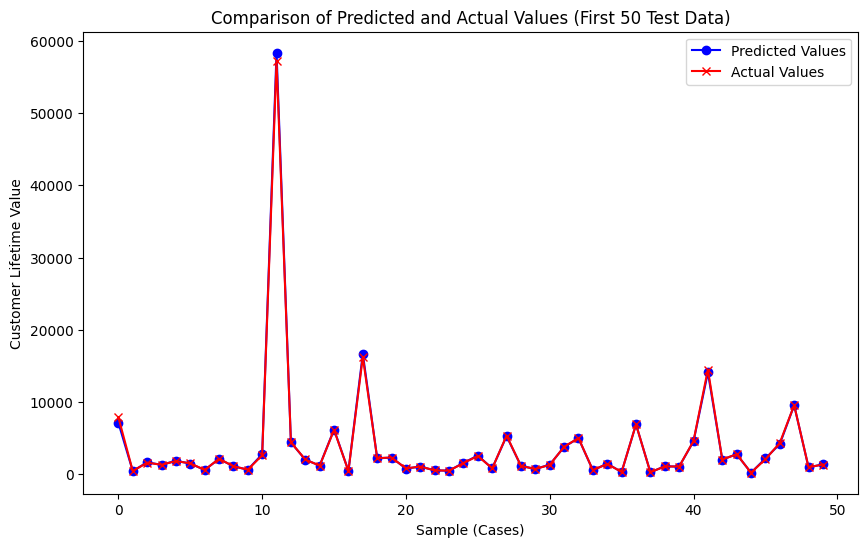

In [91]:
predictions_100 = predictions[:50]

actual = np.array(ytest)
actual_100 = actual[:50]

# Plotting
plt.figure(figsize=(10, 6))  
plt.plot(predictions_100, label='Predicted Values', color='blue', marker='o') 
plt.plot(actual_100, label='Actual Values', color='red', marker='x') 

plt.title('Comparison of Predicted and Actual Values (First 50 Test Data)') 
plt.xlabel('Sample (Cases)')  
plt.ylabel('Customer Lifetime Value')  
plt.legend()  

plt.show()

#### **New Customers CLV Prediction**

In [92]:
newpredict = model_pipeline.predict(newcustomers)

In [93]:
newcustomers['Predicted_CLV'] = newpredict

In [94]:
newcustomers

,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan,Predicted_CLV
4,12350.0,Norway,17,19.670588,309,inf,0.0,336.3615
5,12351.0,Unspecified,21,14.330000,374,inf,0.0,302.2085
8,12354.0,Spain,58,18.610345,231,inf,0.0,1067.8008
19,12365.0,Cyprus,22,29.153636,290,inf,0.0,637.5010
20,12366.0,Cyprus,3,166.746667,633,inf,0.0,580.3344
...,...,...,...,...,...,...,...,...
5862,18269.0,United Kingdom,14,24.085714,365,inf,0.0,340.9259
5867,18274.0,United Kingdom,11,15.992727,29,inf,0.0,176.9144
5872,18279.0,United Kingdom,13,17.795385,518,inf,0.0,233.7840
5877,18284.0,United Kingdom,28,16.488571,431,inf,0.0,462.6108


In [95]:
Q1 = newcustomers['Predicted_CLV'].quantile(0.25)
Q3 = newcustomers['Predicted_CLV'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = newcustomers[(newcustomers['Predicted_CLV'] < lower_bound) | (newcustomers['Predicted_CLV'] > upper_bound)]


In [96]:
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
highval = outliers[(outliers['Predicted_CLV'] >= upper_bound)]
highval

Lower Bound: -164.29102499999968, Upper Bound: 749.6295749999997


,customer_id,country,number_of_orders,average_order_value,recency,frequency,customer_lifespan,Predicted_CLV
8,12354.0,Spain,58,18.610345,231,inf,0.0,1067.8008
22,12368.0,Cyprus,18,50.983333,627,inf,0.0,1008.4600
38,12385.0,Belgium,65,29.821538,378,inf,0.0,1946.8903
49,12396.0,RSA,65,14.329692,673,inf,0.0,931.8735
51,12398.0,Switzerland,85,19.243059,45,inf,0.0,1660.5377
...,...,...,...,...,...,...,...,...
5697,18104.0,United Kingdom,38,19.858947,36,inf,0.0,763.4064
5726,18133.0,United Kingdom,1,931.500000,211,inf,0.0,5015.5071
5732,18139.0,United Kingdom,159,53.071321,17,inf,0.0,8370.3131
5785,18192.0,United Kingdom,45,21.288222,71,inf,0.0,986.9636


From 1700 new customers, we have identified **162 customers** whose Predicted Customer Lifetime Value (CLV) is significantly higher than the other new customers.

**Business Implications**:
- `Collect these 162 high value customers detail demographic data so the company can develop specific marketing strategies` to retain and engage these valuable customers.
- Segment customers based on CLV to optimize resource allocation and strategic focus on high-value segments.
- Analyze purchasing behavior and preferences of these 162 customers to make personalized offer to these potential high value customers.

### 2. **CHURN**

Metrics to use : **F2 Score**

- **False Positives (FP)**: Customers that our model predicted will churn (1), but they actually did not churn (0).
  - **Impact**: The company might allocate retention resources (discounts, coupons) to these customers unnecessarily. This can lead to increased costs without any actual benefit.
- **False Negatives (FN)**: Customers that our model predicted will not churn (0), but they actually did churn (1).
  - **Impact**: These customers are not targeted with retention efforts, leading to a higher likelihood of them leaving our service(App), which directly impacts revenue. Acquiring new customers is needed which also generate costs.

The impact of False Negatives is that customers may leave our service or application, which is directly affects company revenue. According to an article, acquiring new customers is 5 to 25 times more expensive (depending on the industry) than retaining existing ones. However, allocating retention resources to customers who don’t need them (False Positives) also incurs costs, though less than losing customers. The F2 Score, which is a variation of the F1 Score, provides a weighted emphasis on False Negatives compared to False Positives, making it suitable for situations where False Negatives have a greater and more critical impact.

In [97]:
dfchurn = pd.read_csv('retail_transaction_data.csv')
dfchurn

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [98]:
dfchurn = dfchurn[dfchurn['quantity'] > 0]
dfchurn = dfchurn.dropna(subset=['customer_id'])

In [99]:
dfchurn

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


#### a. Create New Churn Dataset

- Identify Favorite Products for each customer - for personalization by recommending the right products to the right users, or in short: which products we should offer to them.

In [121]:
dfchurn['order_date'] = pd.to_datetime(dfchurn['order_date'])
favorite_product = dfchurn.groupby(['customer_id', 'product_description']).agg({'quantity': 'sum'}).reset_index()
favorite_product = favorite_product.loc[favorite_product.groupby('customer_id')['quantity'].idxmax()]

- Calculate Customer Lifespan - to determine the duration a customer has been active with the company, from their first purchase to their last purchase. This helps in understanding customer retention and the overall relationship duration.

In [101]:
customer_lifespan = dfchurn.groupby('customer_id').agg(
    first_purchase=('order_date', 'min'),
    last_purchase=('order_date', 'max')
).reset_index()
customer_lifespan['customer_lifespan'] = (customer_lifespan['last_purchase'] - customer_lifespan['first_purchase']).dt.days

- Calculate Average Order Value - to determine the average amount spent per order by each customer, which helps in understanding spending behavior and assessing the value generated from each transaction

In [102]:
order_value = dfchurn.assign(order_revenue=lambda x: x['quantity'] * x['unit_price'])
average_order_value = order_value.groupby('customer_id').agg(
    total_revenue=('order_revenue', 'sum'),
    total_orders=('order_id', 'nunique')
).reset_index()
average_order_value['average_order_value'] = average_order_value['total_revenue'] / average_order_value['total_orders']


- Determine Churn - from the customer data by identifying those who have not made a purchase within the past year, which helps in classifying customers who have likely stopped engaging with the business.

In [103]:
last_order_date = dfchurn['order_date'].max()
cutoff_date = last_order_date - pd.Timedelta(days=365)
customer_churn = customer_lifespan.copy()
customer_churn['churn'] = (customer_churn['last_purchase'] < cutoff_date).astype(int)

In [104]:
customer_df = customer_lifespan[['customer_id']].merge(
    favorite_product[['customer_id', 'product_description']],
    on='customer_id'
).merge(
    customer_lifespan[['customer_id', 'customer_lifespan']],
    on='customer_id'
).merge(
    average_order_value[['customer_id', 'average_order_value']],
    on='customer_id'
).merge(
    customer_churn[['customer_id', 'churn']],
    on='customer_id'
)

# Add the country column
customer_df = customer_df.merge(dfchurn[['customer_id', 'country']].drop_duplicates(), on='customer_id')

# Rename columns for clarity
customer_df = customer_df.rename(columns={
    'product_description': 'favorite_product',
    'customer_lifespan': 'customer_lifespan_days'
})

# Display the resulting dataframe
customer_df

,customer_id,favorite_product,customer_lifespan_days,average_order_value,churn,country
0,12346.0,MEDIUM CERAMIC TOP STORAGE JAR,400,6463.038333,0,United Kingdom
1,12347.0,ICE CREAM SUNDAE LIP GLOSS,402,704.165000,0,Iceland
2,12348.0,DOUGHNUT LIP GLOSS,362,403.880000,0,Finland
3,12349.0,SWEETHEART CERAMIC TRINKET BOX,570,1107.172500,0,Italy
4,12350.0,TEA BAG PLATE RED RETROSPOT,0,334.400000,0,Norway
...,...,...,...,...,...,...
5889,18283.0,10 COLOUR SPACEBOY PEN,654,124.393182,0,United Kingdom
5890,18284.0,RED SPOTS WRAP,0,461.680000,1,United Kingdom
5891,18285.0,PAPER BUNTING WHITE LACE,0,427.000000,1,United Kingdom
5892,18286.0,DINOSAUR KEYRINGS ASSORTED,247,648.215000,1,United Kingdom


In [105]:
newcustomers = customer_df[(customer_df['customer_lifespan_days'] == 0)]
newcustomers.drop(['churn'], axis=1, inplace=True)

In [106]:
newcustomers

,customer_id,favorite_product,customer_lifespan_days,average_order_value,country
4,12350.0,TEA BAG PLATE RED RETROSPOT,0,334.40,Norway
5,12351.0,BLUE SCANDINAVIAN PAISLEY WRAP,0,300.93,Unspecified
8,12354.0,BLUE POLKADOT CUP,0,1079.40,Spain
19,12365.0,ASSORTED BOTTLE TOP MAGNETS,0,320.69,Cyprus
20,12366.0,ASSORTED COLOUR BIRD ORNAMENT,0,500.24,Cyprus
...,...,...,...,...,...
5875,18269.0,10 COLOUR SPACEBOY PEN,0,337.20,United Kingdom
5880,18274.0,FAIRY CAKE FLANNEL ASSORTED COLOUR,0,175.92,United Kingdom
5885,18279.0,FROSTED BOX 9 WHITE T-LIGHT CANDLES,0,231.34,United Kingdom
5890,18284.0,RED SPOTS WRAP,0,461.68,United Kingdom


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.metrics import make_scorer, fbeta_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

#### b. Feature Engineering

In [108]:
preprocessor = ColumnTransformer(
    transformers=[
        ('rob', RobustScaler(), ['average_order_value']),
        ('bin_enc', ce.BinaryEncoder(), ['country', 'favorite_product'])
    ],
    remainder='passthrough' 
)

In [109]:
x = customer_df.drop(['customer_id', 'churn'], axis=1)
y = customer_df['churn']

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y, 
    test_size=0.2, 
    random_state=2024)

#### d. Model Benchmarking

In [110]:
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
svc = SVC(probability=True)
forest = RandomForestClassifier()

In [111]:
models = [logreg, knn, dt, svc, forest]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC', 'Random Forest']
f2_scores_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Define the custom F2 score
f2_scorer = make_scorer(fbeta_score, beta=2)

for model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])

    cv_scores = cross_val_score(model_pipeline, x, y, cv=kfold, scoring=f2_scorer)

    f2_scores_list.append(cv_scores.mean())

df_benchmark = pd.DataFrame({
    'Model': model_names,
    'AVG F2': f2_scores_list
})

print(df_benchmark.sort_values('AVG F2', ascending=False))

                 Model    AVG F2
3                  SVC  0.629437
0  Logistic Regression  0.575533
4        Random Forest  0.486147
2        Decision Tree  0.469989
1                  KNN  0.464452


SVC is the best algorithm for this case

#### e. Resampler Benchmarking

In [112]:
class_counts = customer_df['churn'].value_counts()
total_rows = len(customer_df)

class_percentage = class_counts / total_rows


print(class_percentage)

churn
0    0.726502
1    0.273498
Name: count, dtype: float64


Our data is imbalance (73% Negative class & 27 Positive class). A Resampler may be needed.

In [113]:
resampling_methods = {
    'RandomUnderSampler': RandomUnderSampler(random_state=2024),
    'RandomOverSampler': RandomOverSampler(random_state=2024),
    'SMOTE': SMOTE(random_state=2024),
    'NearMiss': NearMiss(),
}

results = {}

for name, method in resampling_methods.items():
    pipeline_resample_rf = ImbPipeline([
        ('preprocessing', preprocessor),
        ('resampling', method),
        ('model', svc)
    ])

    cv_scores = cross_val_score(model_pipeline, x, y, cv=kfold, scoring=f2_scorer)

    results[name] = cv_scores.mean()

for resampling_method, f2 in results.items():
    print(f'{resampling_method}: {f2:.4f}')

RandomUnderSampler: 0.4839
RandomOverSampler: 0.4741
SMOTE: 0.4907
NearMiss: 0.4973


NearMiss is the most accurate type of resampling for this case, but not as good as the model without resampling. we will keep the SVC model that is not using resampling.

#### f. Hyperparameter Tuning

our model score is not good enough (62.9% f2 score). Hyperparameter tuning might be needed.

In [114]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from scipy.stats import uniform, randint


param_dist = {
    'classifier__C': uniform(0.1, 1),  
    'classifier__kernel': ['linear', 'rbf'],  
    'classifier__gamma': uniform(0.1, 1)  
}

svc_model = SVC()
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2024)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', svc_model)])

random_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, 
                                   n_iter=10,  
                                   cv=kfold, 
                                   scoring=f2_scorer, 
                                   n_jobs=-1, 
                                   random_state=2024)

random_search.fit(xtrain, ytrain)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters found:", best_params)
print("Best F2 score:", best_score)

Best parameters found: {'classifier__C': 0.35799563807819357, 'classifier__gamma': 0.19554215386036547, 'classifier__kernel': 'rbf'}
Best F2 score: 0.5289540808770617


Our best parameters on the hypertuning is not as high as the default parameters. We will be using the default parameters for the final model

In [115]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', SVC(probability=True))])

model_pipeline.fit(xtrain, ytrain)

predictions = model_pipeline.predict(xtest)


f2_score = fbeta_score(ytest, predictions, beta=2)
print("F2 score on the test set: ", f2_score)

F2 score on the test set:  0.6282722513089005


In [116]:
print("Classification report:\n", classification_report(ytest, predictions))

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81       854
           1       0.52      0.66      0.58       325

    accuracy                           0.74      1179
   macro avg       0.69      0.71      0.69      1179
weighted avg       0.76      0.74      0.74      1179



In [117]:
probaresult = xtest.copy()


proba = model_pipeline.predict_proba(xtest)[:,1]
probaresult['Probability'] = proba

probaresult

,favorite_product,customer_lifespan_days,average_order_value,country,Probability
287,WOODLAND CHARLOTTE BAG,420,535.405714,Germany,0.111822
1700,EDWARDIAN PARASOL NATURAL,735,606.324324,United Kingdom,0.132051
5682,T-LIGHT HOLDER WHITE LACE,0,151.490000,United Kingdom,0.575045
3235,GIN + TONIC DIET METAL SIGN,540,281.685000,United Kingdom,0.075358
3327,POTTING SHED TEA MUG,497,173.676667,United Kingdom,0.084614
...,...,...,...,...,...
1856,MAGIC DRAWING SLATE BUNNIES,456,283.525000,United Kingdom,0.098146
3392,ASSTD DESIGN BUBBLE GUM RING,604,337.512222,United Kingdom,0.073690
2031,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,14,67.370000,United Kingdom,0.494436
1392,VINTAGE BEAD PINK EVENING BAG,145,222.810000,United Kingdom,0.144283


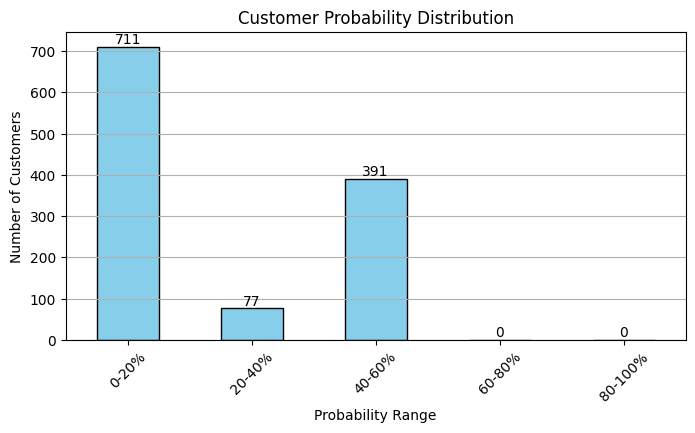

In [118]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

probaresult['Probability Range'] = pd.cut(probaresult['Probability'], bins=bins, labels=labels)

bin_counts = probaresult['Probability Range'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
ax = bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for i in ax.containers:
    ax.bar_label(i)

plt.title('Customer Probability Distribution')
plt.xlabel('Probability Range')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

The bar chart visualizes the probability distribution of customer churn as predicted by our model (from test data). The chart categorizes customers into distinct probability ranges, reflecting their likelihood of churning.
- **0-20% Probability Range**: 711 Customers fall into this category. This indicates that a significant portion of our customer base is predicted to have a low probability of churning.
- **20-40% Probability Range**: 77 Customers are predicted to have a churn probability within this range. While this number is smaller compared to the 0-20% range, it still represents a portion of the customers that could be at moderate risk of churning.
- **40-60% Probability Range**: 391 Customers are classified in this range. This is the most substantial group after the 0-20% category. Customers in the 40-60% probability range are at a higher risk of churning compared to those in the previous categories.
- **60-80% and 80-100% Probability**: Notably, there are no customers in these higher probability ranges. This absence suggests that, according to our model, there are no customers predicted to have a very high likelihood of churning.


#### g. New Customers Churn Prediction

In [119]:
probaresult = newcustomers.copy()


proba = model_pipeline.predict_proba(newcustomers)[:,1]
probaresult['Probability'] = proba

probaresult

,customer_id,favorite_product,customer_lifespan_days,average_order_value,country,Probability
4,12350.0,TEA BAG PLATE RED RETROSPOT,0,334.40,Norway,0.574464
5,12351.0,BLUE SCANDINAVIAN PAISLEY WRAP,0,300.93,Unspecified,0.574162
8,12354.0,BLUE POLKADOT CUP,0,1079.40,Spain,0.573855
19,12365.0,ASSORTED BOTTLE TOP MAGNETS,0,320.69,Cyprus,0.574602
20,12366.0,ASSORTED COLOUR BIRD ORNAMENT,0,500.24,Cyprus,0.574380
...,...,...,...,...,...,...
5875,18269.0,10 COLOUR SPACEBOY PEN,0,337.20,United Kingdom,0.574399
5880,18274.0,FAIRY CAKE FLANNEL ASSORTED COLOUR,0,175.92,United Kingdom,0.574778
5885,18279.0,FROSTED BOX 9 WHITE T-LIGHT CANDLES,0,231.34,United Kingdom,0.574823
5890,18284.0,RED SPOTS WRAP,0,461.68,United Kingdom,0.574675


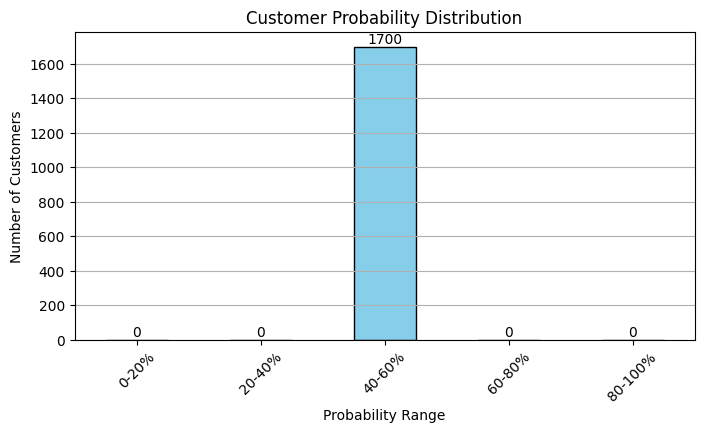

In [120]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

probaresult['Probability Range'] = pd.cut(probaresult['Probability'], bins=bins, labels=labels)

bin_counts = probaresult['Probability Range'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
ax = bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for i in ax.containers:
    ax.bar_label(i)

plt.title('Customer Probability Distribution')
plt.xlabel('Probability Range')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

The prediction for new customers reveals that all of them fall within the **40-60% probability** range for churn. This indicates that our new customers are at a moderate risk of churning. Given this insight, it’s important to implement targeted retention strategies for this segment to improve customer loyalty and reduce potential churn.
- Create a personalized promo/discount based on the customers favorite product (the customers favorite product was shown on the dataset)
- Ensure that new customers have easy access to support and resources. Prompt and effective customer service can address issues before they lead to dissatisfaction and churn.
- Offer incentives, such as discounts or loyalty rewards, to encourage new customers to stay engaged and make repeat purchases